**Imports & Setup**

In [1]:
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix, make_scorer
import pandas as pd
import matplotlib.pyplot as plt

2025-11-04 21:04:48.126643: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-04 21:04:48.835411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-04 21:04:50.343404: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# directories & file paths
TRAIN_DIR = Path("../../data/processed_balanced/train")
IMG_DIR = Path("../../data/processed")
VAL_DIR = IMG_DIR / "validate"
TEST_DIR = IMG_DIR / "test"
EXTS = (".jpg", ".jpeg", ".png", ".bmp")
RESULTS_DIR = Path("./results")
RESULTS_PATH = RESULTS_DIR / "dt_results.csv"
EXTS = (".jpg", ".jpeg", ".png", ".bmp")

# target styles for classification
TARGET_STYLES = [
    "Abstract_Expressionism",
    "Baroque",
    "Cubism",
    "Impressionism",
    "Pop_Art"
]

**Extracting Features**

In [3]:
# config for data loading & feature extraction
BATCH = 64
AUTO = tf.data.AUTOTUNE
EXPECT_SIZE = (256, 256)
STRICT_SIZE = True
PCA_COMPONENTS = 256

# mapping from class name to label index
CLASS_TO_IDX = {c:i for i,c in enumerate(TARGET_STYLES)}
def list_paths_labels(root: Path):
    paths, labels = [], []
    for cls in TARGET_STYLES:
        cls_dir = root / cls
        if not cls_dir.exists(): 
            continue
        for p in sorted(cls_dir.rglob("*")):
            if p.suffix.lower() in EXTS and p.is_file():
                paths.append(str(p))
                labels.append(CLASS_TO_IDX[cls])
    return np.array(paths), np.array(labels, dtype=np.int32)

def decode_keep_size(path):
    '''
    decode image from path, keep 256 size if STRICT_SIZE is true
    '''
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    if STRICT_SIZE:
        shape = tf.shape(img)
        assert_op = tf.debugging.assert_equal(shape[:2], EXPECT_SIZE, message="Non-256 image found")
        with tf.control_dependencies([assert_op]):
            img = tf.identity(img)
    img = tf.cast(img, tf.float32)
    img = resnet50.preprocess_input(img)
    return img

def build_ds(paths, labels=None, shuffle=False):
    '''
    build tf.data.Dataset from image paths & labels
    '''
    x = tf.data.Dataset.from_tensor_slices(paths)
    x = x.map(decode_keep_size, num_parallel_calls=AUTO)
    if labels is not None:
        y = tf.data.Dataset.from_tensor_slices(labels)
        ds = tf.data.Dataset.zip((x, y))
    else:
        ds = x
    if shuffle:
        ds = ds.shuffle(buffer_size=min(10000, len(paths)), seed=42, reshuffle_each_iteration=False)
    ds = ds.batch(BATCH).prefetch(AUTO)
    return ds

# load backbone model from keras applications
backbone = resnet50.ResNet50(include_top=False, weights="imagenet", pooling="avg")
train_paths, y_train = list_paths_labels(TRAIN_DIR)
val_paths, y_val = list_paths_labels(VAL_DIR)
test_paths, y_test = list_paths_labels(TEST_DIR)

# build datasets
train_ds = build_ds(train_paths, y_train, shuffle=False)
val_ds = build_ds(val_paths, y_val, shuffle=False)
test_ds = build_ds(test_paths, y_test, shuffle=False)

# extract features
X_train = backbone.predict(train_ds, verbose=1)
X_val = backbone.predict(val_ds, verbose=1)
X_test = backbone.predict(test_ds, verbose=1)
print("Non-PCA shapes:", X_train.shape, X_val.shape, X_test.shape)

# use pca to reduce feature dimensionality for decision tree forest
pca = PCA(n_components=PCA_COMPONENTS, random_state=635, svd_solver="auto", whiten=False)
X_train_p = pca.fit_transform(X_train)
X_val_p = pca.transform(X_val)
X_test_p = pca.transform(X_test)
print("PCA shapes:", X_train_p.shape, X_val_p.shape, X_test_p.shape)

E0000 00:00:1762311919.419347  210780 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1762311919.427358  210780 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


235/235 ━━━━━━━━━━━━━━━━━━━━ 597s 3s/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step
Non-PCA shapes: (15000, 2048) (4760, 2048) (4761, 2048)
PCA shapes: (15000, 256) (4760, 256) (4761, 256)


**Decision Tree Forest**

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 600} , Best CV MCC: 0.8224020849388249


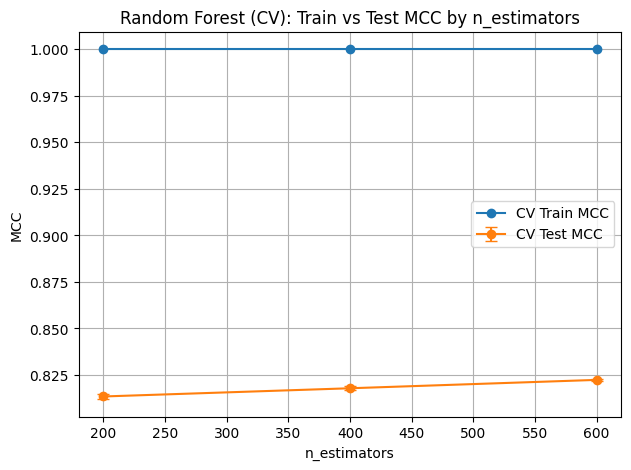

VAL MCC: 0.7328701966681525 , ACCURACY: 0.8210084033613445
TEST MCC: 0.7309228607179477 , ACCURACY: 0.8191556395715186

Test classification report:
                        precision    recall  f1-score   support

Abstract_Expressionism       0.63      0.75      0.68       557
               Baroque       0.75      0.87      0.81       848
                Cubism       0.72      0.79      0.76       447
         Impressionism       0.94      0.84      0.89      2612
               Pop_Art       0.63      0.63      0.63       297

              accuracy                           0.82      4761
             macro avg       0.74      0.78      0.75      4761
          weighted avg       0.83      0.82      0.82      4761


Confusion matrix (test):
[[ 415    5   40   35   62]
 [  18  741   19   69    1]
 [  35    9  354   14   35]
 [ 138  218   41 2203   12]
 [  54    9   35   12  187]]


In [6]:
# hyperparameters for dt grid search
RF_PARAM_GRID = {"n_estimators": [200, 400, 600], "max_depth": [None, 20, 40], "max_features": ["sqrt"], "min_samples_leaf": [1, 4]}
RANDOM_STATE = 635

# set up random forest with grid search
rf = RandomForestClassifier(class_weight="balanced_subsample", n_jobs=-1, random_state=RANDOM_STATE)
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)
mcc_scorer = make_scorer(matthews_corrcoef)
gs = GridSearchCV(estimator=rf, param_grid=RF_PARAM_GRID, cv=cv, scoring=mcc_scorer, return_train_score=True, n_jobs=-1, verbose=1)

# fit grid search with pca training data
gs.fit(X_train_p, y_train)

# save results to csv
gs_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)
gs_df.to_csv("./results/dt_results_pca.csv", index=False)
print("Best parameters:", gs.best_params_, ", Best CV MCC:", gs.best_score_)

# plot results of different n_estimators values
key = "param_n_estimators"
best_per_n = gs_df.loc[gs_df.groupby(key)["mean_test_score"].idxmax()].copy()
best_per_n["n_estimators"] = best_per_n[key].astype(int)
best_per_n = best_per_n.sort_values("n_estimators")
x = best_per_n["n_estimators"].values
mean_train = best_per_n["mean_train_score"].values
mean_test = best_per_n["mean_test_score"].values
std_test = best_per_n["std_test_score"].values
plt.figure(figsize=(7,5))
plt.plot(x, mean_train, marker='o', label='CV Train MCC')
plt.errorbar(x, mean_test, yerr=std_test, marker='o', capsize=4, label='CV Test MCC')
plt.xlabel('n_estimators')
plt.ylabel('MCC')
plt.title('Random Forest (CV): Train vs Test MCC by n_estimators')
plt.grid(True)
plt.legend()
plot_path = RESULTS_DIR / "dt_plot_pca.png"
plt.savefig(plot_path, bbox_inches='tight', dpi=150)
plt.show()

# evaluate best params on test
best_model = gs.best_estimator_
val_pred = best_model.predict(X_val_p)
test_pred = best_model.predict(X_test_p)

# print evaluation metrics
print("VAL MCC:", matthews_corrcoef(y_val,  val_pred), ", ACCURACY:", accuracy_score(y_val,  val_pred))
print("TEST MCC:", matthews_corrcoef(y_test, test_pred), ", ACCURACY:", accuracy_score(y_test, test_pred))
print("\nTest classification report:")
print(classification_report(y_test, test_pred, target_names=TARGET_STYLES))
print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, test_pred))